To begin, it is necessary to import everything we will need from PyTorch. I used Pandas for my dataframe creation, PyTorch for my neural network (including Dataset and Dataloader for implementing the data into a Dataset class from the Loaders), scikit-learn for its train/test split and standard scaler, matplotlib and seaborn for visualizing the data/features/confusion matrix

In [61]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


Next, I need to import the data from the csv files provided on canvas. I used Pandas' pf.read_csv to import both csv files, then I concatenated them for a single dataset. Finally, I shuffled them with df.sample, so that it had better generalization.

In [62]:
df1 = pd.read_csv("../Project 2 - Bonus/pirvision_fog_presence_detection (1)/pirvision_office_dataset1.csv") #This is dataset 1
df2 = pd.read_csv("../Project 2 - Bonus/pirvision_fog_presence_detection (1)/pirvision_office_dataset2.csv") #This is dataset 2

df = pd.concat([df1, df2], ignore_index=True) #This concatenates the datasets together into one large dataset called 'df'

df = df.sample(frac=1, random_state=42).reset_index(drop=True) #This shuffles the dataframe, so that the model isn't seeing all of df1 then all of df2

Next, it is much easier for PyTorch if the labels are numerically aligned - having the labels 0, 1, 3 is a little inconvenient. Therefore, I just use a simple block of making our 'X' equal to column 3 and onwards using iloc, while I label column 2 as our y values (labels). Then, for convenience, I replaced the '3' labels with '2' labels.

In [63]:
X = df.iloc[:, 3:].copy() #This separates all the columns from 3 onwards into the X values
y = df.iloc[:, 2].copy() #This makes the y values our second column

y = y.replace(3, 2) #This replaces any label of 3 with a label of 2 in our y values

Next, we need to scale our data. If we don't use some form of scaling, the weights won't have the same numerical impact - a weight of 1000 will mean much more than a weight of 1, especially when we are looking at different categories (such as a one-hot binary value versus a scalar value up to a thousand). In our case, the Temperature column would be vastly different than the PIR columns, since it is scaled differently - hence, we use a scaler. This just puts the values on a relative 'scale', with a standard deviation of 1 (they are scaled 0-1). Then, I use PyTorch's train_test_split to make some scaled x values for testing. 20% of the x values become test values.

In [64]:
scaler = StandardScaler() #This is the scaler from PyTorch
X_scaled = scaler.fit_transform(X) #This is the function that scales the data, which I made X

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42) #Here we make 20% of the data part of our test set

Next, we need to make a dataset class, which I call PIRDataset. Having a Dataset class makes it much easier for PyTorch, with DataLoader especially. Therefore, I make a basic class with self.X and self.y as we had above (but they are now tensors obviously).

In [65]:
class PIRDataset(Dataset):
    def __init__(self, X, y): #This is a pretty basic initialization of a dataset class
        self.X = torch.tensor(X, dtype=torch.float32) #Here we make our X tensor for inputs
        self.y = torch.tensor(y.values, dtype=torch.long) #Here we make our y values tensor for labels

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx): #This can help us index for specific values later on
        return self.X[idx], self.y[idx]

Next, we make our training/testing datasets/loaders with the class we have above, as well as PyTorch's DataLoader. For the training and testing datasets, we just call the class with the training or testing values. For the loaders, I thought a batch of 64 size was sufficient. Also, we want to shuffle the training set for randomness/generalization, but not the validation set.

In [66]:
train_dataset = PIRDataset(X_train, y_train) #Here we make the training set
test_dataset = PIRDataset(X_test, y_test) #Here we make the testing set

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) #Here we make a loader from our training set
test_loader = DataLoader(test_dataset, batch_size=64) #Here we make a loader from our testing set

Now, it is time to actually make the model. We have the datasets as loaders, which we can return to in a bit. For now, we declare some basic input dimensions, hidden dimensions, and our output dimensions (3, for 3 classes). Our input dim is going to be 56, since there are 55 PIR features and 1 Temperature feature (columns). I also chose the hidden dimensions to be 128, as this is a common choice relative to these dimensions. It's about 2-3 times that of the inputs, which usually performs well. I used ReLU as the activation function (it is typically the best option) with some Dropout to generalize/normalize a little better. We end up with one input layer, then ReLU, then some dropout, then a hidden layer, then some more ReLU, then a final output layer with 3 dimensions.

In [67]:
class PIRClassifier(nn.Module):
    def __init__(self, input_dim=56, hidden_dim=128, output_dim=3):
        super(PIRClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)

This part, the optimization, is very basic. We are making 'model' to be our class we created above. I chose Cross Entropy as our Loss function, with Adam optimizing it. These options are typically the golden standard (different loss functions can be excellent as well).

In [68]:
model = PIRClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Here is where we actually train the model. For a given number of epochs, we run through a loop, cumulating running loss for each batch in the Loader we created (for now, just the training set as its loader). We use our optimizer, then calculate the loss for backpropagation. 

In [69]:
for epoch in range(20):
    model.train()
    running_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

Epoch 1, Loss: 0.2961
Epoch 2, Loss: 0.0455
Epoch 3, Loss: 0.0363
Epoch 4, Loss: 0.0279
Epoch 5, Loss: 0.0255
Epoch 6, Loss: 0.0216
Epoch 7, Loss: 0.0206
Epoch 8, Loss: 0.0181
Epoch 9, Loss: 0.0176
Epoch 10, Loss: 0.0180
Epoch 11, Loss: 0.0190
Epoch 12, Loss: 0.0176
Epoch 13, Loss: 0.0171
Epoch 14, Loss: 0.0140
Epoch 15, Loss: 0.0147
Epoch 16, Loss: 0.0112
Epoch 17, Loss: 0.0104
Epoch 18, Loss: 0.0129
Epoch 19, Loss: 0.0169
Epoch 20, Loss: 0.0112


Finally, we test the model to see how well it did. I set the model to evaluate, then see how much was correct in its predictions. I get the testing loader, and call the model for one of its x batches. 

In [70]:
model.eval()
correct = total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 99.51%


This portions is the creation of the feature visualization. I chose some random feature indices, from which I can plot them as a histplot using matplotlib. For each index, I grabbed its corresponding feature and label, and compared its prediction to see how much of a factor each feature was, and what it pointed to.

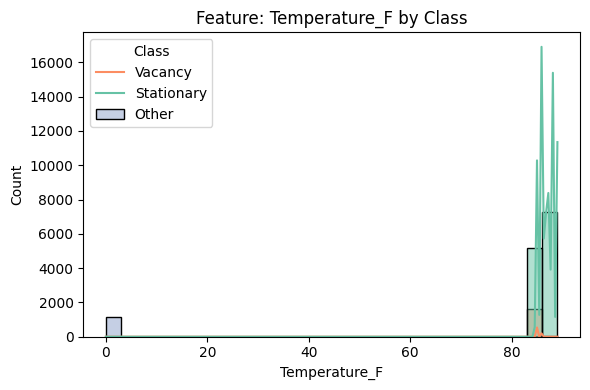

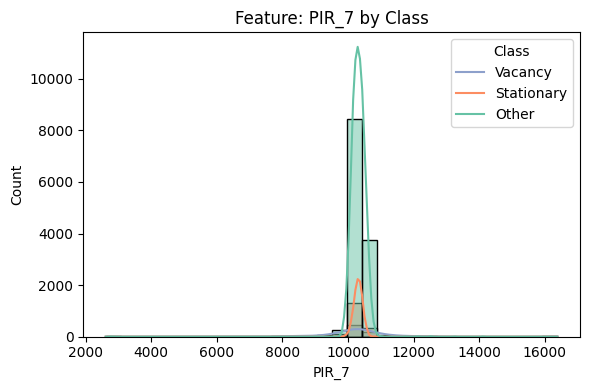

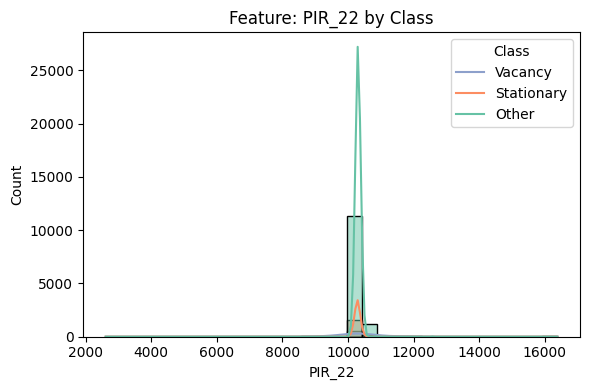

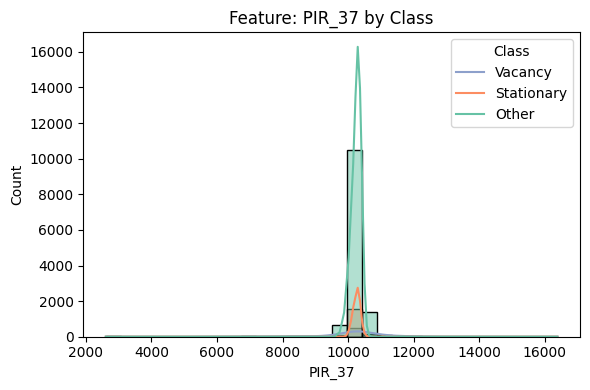

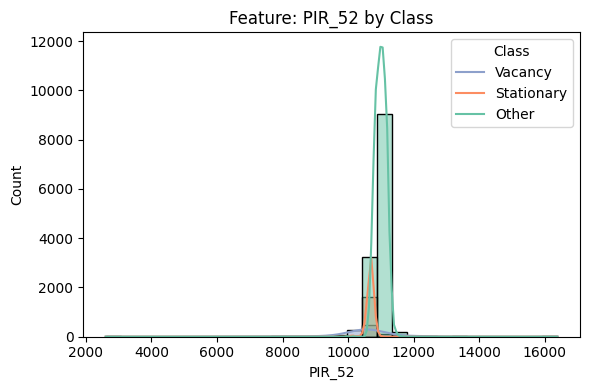

In [71]:
feature_indices = [3, 10, 25, 40, 55] 
feature_names = df.columns[3:]

df['label'] = df.iloc[:, 2]

for idx in feature_indices:
    feature = feature_names[idx - 3]
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=feature, hue='label', bins=30, kde=True, palette='Set2')
    plt.title(f"Feature: {feature} by Class")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.legend(title="Class", labels=["Vacancy", "Stationary", "Other"])
    plt.tight_layout()
    plt.show()

This is where I used PCA to flatten and visualize the X_scaled tensor I created. The PCA will show a cluster map after flattening the important features into PCA1 and PCA2, which are then plotted against each other to represent the data visually.

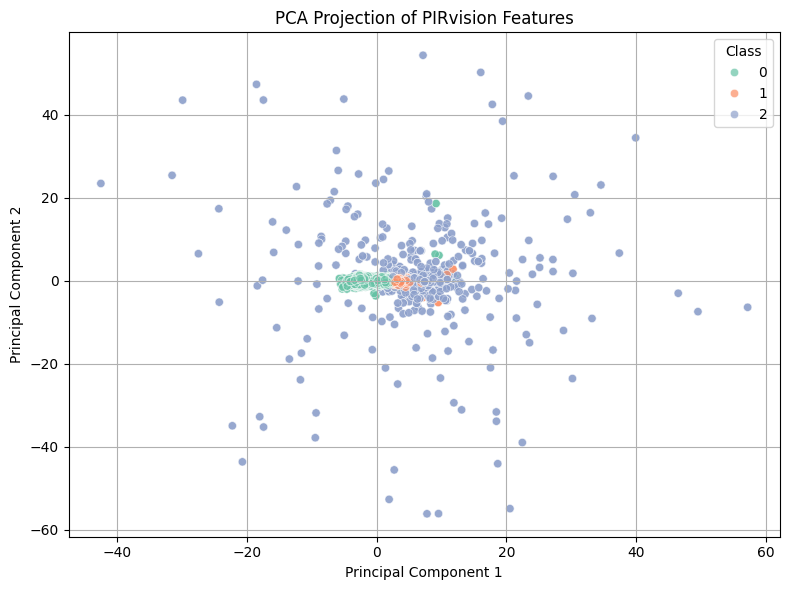

In [72]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="Set2", alpha=0.7)
plt.title("PCA Projection of PIRvision Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Class")
plt.grid(True)
plt.tight_layout()
plt.show()


Here is where I calculated my classification report and made a confusion matrix. For each input and its label within the test loader, I ran the model to predict the result. Then, I converted them to numpy arrays, and reported them for each class. Finally, I made a confusion matrix to show the accuracy of the model in a different way.

Classification Report:
              precision    recall  f1-score   support

     Vacancy       0.99      1.00      1.00      2510
  Stationary       1.00      0.96      0.98       314
      Motion       1.00      1.00      1.00       237

    accuracy                           1.00      3061
   macro avg       1.00      0.99      0.99      3061
weighted avg       1.00      1.00      1.00      3061



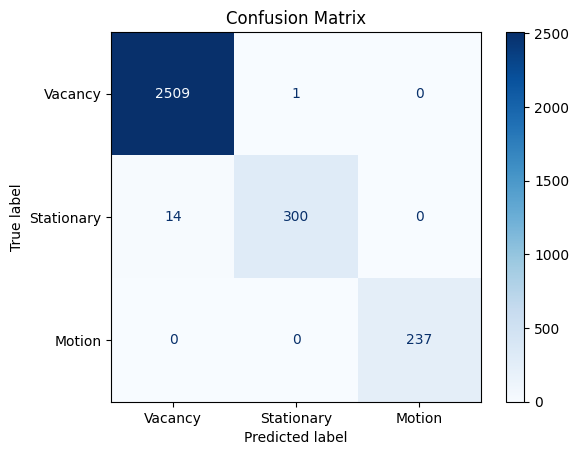

In [73]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Vacancy", "Stationary", "Motion"]))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Vacancy", "Stationary", "Motion"])
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()
